# `HFSModel` Hyperfine Anomalies

Trey V. Wenger (c) June 2025

`HFSModel` can also account for a non-CTEX effects. `HFSModel` considers the detailed balance between all states in the `mol_data` dictionary. Each state's statistical weight is a free parameter drawn from a Dirichlet distribution. The Dirichlet distribution is defined by a hyperparameter, `CTEX_variance`, which controls the statistical weight deviations from the CTEX values. As `CTEX_variance` goes to zero, the weights go to the CTEX values. Note that we make no physical inference about the CTEX deviations, we just ensure that the solution is physical (i.e., that detailed balance is maintained).

In [1]:
# General imports    
import time

import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
import numpy as np
import pymc as pm

print("pymc version:", pm.__version__)
print("arviz version:", az.__version__)

import bayes_spec
print("bayes_spec version:", bayes_spec.__version__)

import bayes_hfs
print("bayes_hfs version:", bayes_hfs.__version__)

# Notebook configuration
pd.options.display.max_rows = None

pymc version: 5.22.0
arviz version: 0.22.0dev
bayes_spec version: 1.9.0
bayes_hfs version: 0+untagged.1.g261bad7.dirty


## Preparing Molecule Data

Here we model the hyperfine structure of CN transitions to the ground rotational state.

In [2]:
from bayes_hfs import get_molecule_data, supplement_molecule_data
import pickle

try:
    all_mol_data_12CN, all_mol_metadata_12CN = get_molecule_data("CN, v=0,1", fmin=100.0, fmax=200.0)
    with open("mol_data_12CN.pkl", "wb") as f:
        pickle.dump(all_mol_data_12CN, f)
    with open("mol_metadata_12CN.pkl", "wb") as f:
        pickle.dump(all_mol_metadata_12CN, f)
except:
    with open("mol_data_12CN.pkl", "rb") as f:
        all_mol_data_12CN = pickle.load(f)
    with open("mol_metadata_12CN.pkl", "rb") as f:
        all_mol_metadata_12CN = pickle.load(f)

all_mol_data_12CN.pprint_all()

    FREQ     ERR    LGINT   DR    ELO    GUP MOLWT TAG  QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l    name    Lab 
    MHz      MHz   nm2 MHz       1 / cm        u                                                                             
----------- ------ ------- --- --------- --- ----- ---- ----- --- --- --- --- --- --- --- --- --- --- --- --- --------- -----
 112101.656   0.05 -8.0612   2 2042.4216   2    26 5041   234   1   1   1   1  --  --   0   1   1   2  --  -- CN, v=0,1  True
 112128.989   0.05  -8.069   2 2042.4222   4    26 5041   234   1   1   1   2  --  --   0   1   1   1  --  -- CN, v=0,1  True
 112148.503   0.05 -7.9593   2 2042.4216   4    26 5041   234   1   1   1   2  --  --   0   1   1   2  --  -- CN, v=0,1  True
 112442.806   0.05 -7.9569   2 2042.4222   4    26 5041   234   1   1   2   2  --  --   0   1   1   1  --  -- CN, v=0,1  True
 112445.015   0.05 -7.5311   2 2042.4216   6    26 5041   234   1   1   2   3  --  --   0   1   1   2  --  -- CN, v=0,

In [3]:
# Keep only Kl = 0 transitions
all_mol_data_12CN = all_mol_data_12CN[all_mol_data_12CN["Kl"] == 0]

# Add GLO
all_mol_data_12CN["GLO"] = 2 * all_mol_data_12CN["F1l"]

all_mol_data_12CN.pprint_all()

    FREQ     ERR    LGINT   DR  ELO   GUP MOLWT TAG  QNFMT  Ju  Ku  vu F1u F2u F3u  Jl  Kl  vl F1l F2l F3l    name    Lab  GLO
    MHz      MHz   nm2 MHz     1 / cm       u                                                                                 
----------- ------ ------- --- ------ --- ----- ---- ----- --- --- --- --- --- --- --- --- --- --- --- --- --------- ----- ---
113123.3701 0.0058 -4.7118   2 0.0007   2    26 5041   234   1   0   1   1  --  --   0   0   1   1  --  -- CN, v=0,1 False   2
113144.1573 0.0057 -3.7989   2   -0.0   2    26 5041   234   1   0   1   1  --  --   0   0   1   2  --  -- CN, v=0,1 False   4
113170.4915 0.0039  -3.809   2 0.0007   4    26 5041   234   1   0   1   2  --  --   0   0   1   1  --  -- CN, v=0,1 False   2
113191.2787 0.0034 -3.6955   2   -0.0   4    26 5041   234   1   0   1   2  --  --   0   0   1   2  --  -- CN, v=0,1 False   4
113488.1202 0.0033 -3.6932   2 0.0007   4    26 5041   234   1   0   2   2  --  --   0   0   1   1  --  -- CN, 

In [4]:
mol_data_12CN = supplement_molecule_data(all_mol_data_12CN, all_mol_metadata_12CN)
print(mol_data_12CN.keys())
print("molecular weight (Daltons):", mol_data_12CN['mol_weight'])
print("transition frequency (MHz):", mol_data_12CN['freq'])
print("Einstein A coefficient (s-1):", mol_data_12CN['Aul'])
print("Relative intensities:", mol_data_12CN['relative_int'])
print("state info:", mol_data_12CN["states"])
print("upper state index:", mol_data_12CN["state_u_idx"])
print("lower state index:", mol_data_12CN["state_l_idx"])
print("upper state degeneracy:", mol_data_12CN["Gu"])
print("lower state degeneracy:", mol_data_12CN["Gl"])

dict_keys(['mol_weight', 'freq', 'Aul', 'relative_int', 'states', 'state_u_idx', 'state_l_idx', 'Gu', 'Gl'])
molecular weight (Daltons): 26
transition frequency (MHz): [113123.3701 113144.1573 113170.4915 113191.2787 113488.1202 113490.9702
 113499.6443 113508.9074 113520.4315]
Einstein A coefficient (s-1): [1.24997446e-06 1.02301076e-05 4.99866053e-06 6.49280964e-06
 6.54458098e-06 1.15851092e-05 1.03265758e-05 5.04267116e-06
 1.26251089e-06]
Relative intensities: [0.01204927 0.09859632 0.09632981 0.12510097 0.12576526 0.33393404
 0.0992112  0.09688593 0.0121272 ]
state info: {'state': [np.str_('0 0 1 1 -- --'), np.str_('0 0 1 2 -- --'), np.str_('1 0 1 1 -- --'), np.str_('1 0 1 2 -- --'), np.str_('1 0 2 1 -- --'), np.str_('1 0 2 2 -- --'), np.str_('1 0 2 3 -- --')], 'deg': array([2, 4, 2, 4, 2, 4, 6]), 'E': array([ 1.00714381e-03, -0.00000000e+00,  5.43007265e+00,  5.43233412e+00,
        5.44813096e+00,  5.44757789e+00,  5.44670753e+00])}
upper state index: [2, 2, 3, 3, 5, 6, 4, 5, 4

## Simulate data

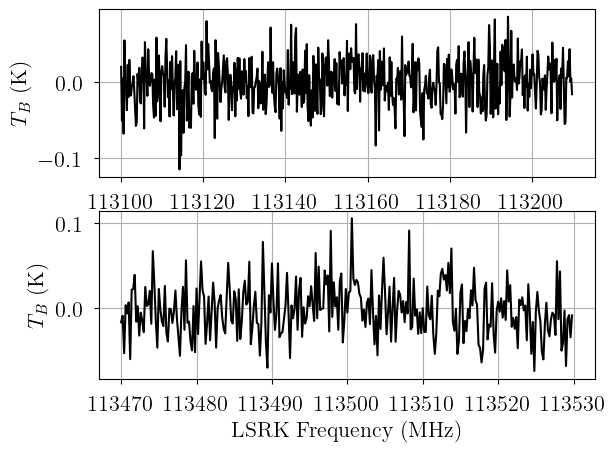

In [5]:
from bayes_spec import SpecData

# spectral axis definition
freq_axis_1 = np.arange(113100.0, 113210.0, 0.2) # MHz
freq_axis_2 = np.arange(113470.0, 113530.0, 0.2) # MHz

# data noise can either be a scalar (assumed constant noise across the spectrum)
# or an array of the same length as the data
noise = 0.03 # K

# brightness data. In this case, we just throw in some random data for now
# since we are only doing this in order to simulate some actual data.
brightness_data_1 = noise * np.random.randn(len(freq_axis_1)) # K
brightness_data_2 = noise * np.random.randn(len(freq_axis_2)) # K

# HFSModel datasets can be named anything, here we name them "12CN-1" and "12CN-2"
obs_1 = SpecData(
    freq_axis_1,
    brightness_data_1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    brightness_data_2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
dummy_data = {"12CN-1": obs_1, "12CN-2": obs_2}

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, dummy_data["12CN-1"].brightness, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, dummy_data["12CN-2"].brightness, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

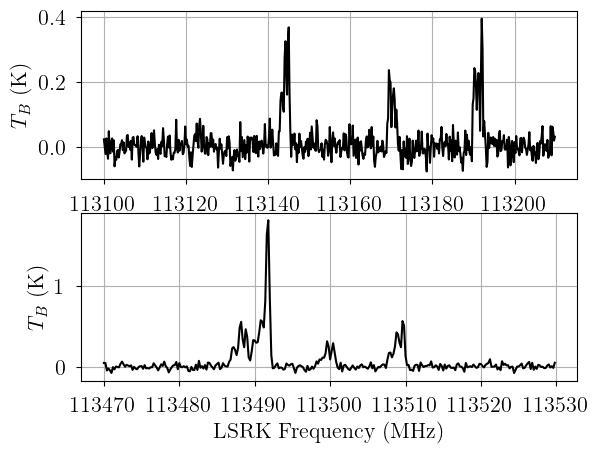

In [6]:
from bayes_hfs import HFSModel

# Initialize and define the model
n_clouds = 3 # number of cloud components
baseline_degree = 0 # polynomial baseline degree
model = HFSModel(
    mol_data_12CN, # molecular data
    dummy_data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_Ntot = [13.5, 0.5], # mean and width of log10 total column density prior (cm-2)
    prior_fwhm2 = 1.0, # width of FWHM^2 prior (km2 s-2)
    prior_velocity = [-3.0, 3.0], # upper and lower limit of velocity prior (km/s)
    prior_log10_Tex_CTEX = [0.75, 0.25], # mean and width of log10 CTEX excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_log10_CTEX_variance = [-4.0, 1.0], # offset and width of log10 CTEX variance prior
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_baseline_coeffs = None, # use default baseline priors
)
model.add_likelihood()

sim_params = {
    "log10_Ntot": np.array([13.8, 13.9, 14.0]),
    "fwhm2": np.array([1.0, 1.25, 1.5])**2.0,
    "velocity": [-2.0, 0.0, 2.5],
    "log10_Tex_CTEX": np.log10([4.46, 3.98, 3.16]),
    "log10_CTEX_variance": [-1.5, -2.0, -3.0],
    "baseline_12CN-1_norm": [0.0],
    "baseline_12CN-2_norm": [0.0],
}

# add derived quantities to sim_params
for key in model.cloud_deterministics + ["weights"]:
    if key not in sim_params.keys():
        sim_params[key] = model.model[key].eval(sim_params, on_unused_input="ignore")

# Evaluate and save simulated observations
sim_obs1 = model.model["12CN-1"].eval(sim_params, on_unused_input="ignore")
sim_obs2 = model.model["12CN-2"].eval(sim_params, on_unused_input="ignore")

# Plot the simulated data
fig, axes = plt.subplots(2)
axes[0].plot(dummy_data["12CN-1"].spectral, sim_obs1, "k-")
axes[0].set_ylabel(dummy_data["12CN-1"].ylabel)
axes[1].plot(dummy_data["12CN-2"].spectral, sim_obs2, "k-")
axes[1].set_xlabel(dummy_data["12CN-2"].xlabel)
_ = axes[1].set_ylabel(dummy_data["12CN-2"].ylabel)

In [7]:
sim_params

{'log10_Ntot': array([13.8, 13.9, 14. ]),
 'fwhm2': array([1.    , 1.5625, 2.25  ]),
 'velocity': [-2.0, 0.0, 2.5],
 'log10_Tex_CTEX': array([0.64933486, 0.59988307, 0.49968708]),
 'log10_CTEX_variance': [-1.5, -2.0, -3.0],
 'baseline_12CN-1_norm': [0.0],
 'baseline_12CN-2_norm': [0.0],
 'CTEX_weights': array([[0.17675213, 0.3535841 , 0.05232473, 0.10459641, 0.0521133 ,
         0.10423952, 0.1563898 ],
        [0.188888  , 0.37787161, 0.04828242, 0.09650998, 0.04806384,
         0.09614104, 0.14424311],
        [0.21695376, 0.43404583, 0.03892456, 0.07779344, 0.03870276,
         0.07741907, 0.11616059]]),
 'Tex': array([[3.10459447, 3.54113325, 3.20254171],
        [3.940404  , 3.51960568, 3.15047797],
        [2.99672069, 3.23793847, 3.28375228],
        [3.76786576, 3.21998793, 3.22904475],
        [3.62429658, 4.02569804, 3.23999777],
        [5.66662915, 3.55058829, 3.16085101],
        [3.48088609, 3.55414756, 3.03307395],
        [4.81182309, 3.99788811, 3.18688088],
        [4

In [8]:
# Now we pack the simulated spectrum into a new SpecData instance
obs_1 = SpecData(
    freq_axis_1,
    sim_obs1,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
obs_2 = SpecData(
    freq_axis_2,
    sim_obs2,
    noise,
    xlabel=r"LSRK Frequency (MHz)",
    ylabel=r"$T_B$ (K)",
)
data = {"12CN-1": obs_1, "12CN-2": obs_2}

## Model Definition

In [9]:
# Initialize and define the model
model = HFSModel(
    mol_data_12CN, # molecular data
    data,
    bg_temp = 2.7, # assumed background temperature (K)
    Beff = 1.0, # beam efficiency
    Feff = 1.0, # forward efficiency
    n_clouds=n_clouds,
    baseline_degree=baseline_degree,
    seed=1234,
    verbose=True
)
model.add_priors(
    prior_log10_Ntot = [13.5, 0.5], # mean and width of log10 total column density prior (cm-2)
    prior_fwhm2 = 1.0, # width of FWHM^2 prior (km2 s-2)
    prior_velocity = [-3.0, 3.0], # upper and lower limit of velocity prior (km/s)
    prior_log10_Tex_CTEX = [0.75, 0.25], # mean and width of log10 CTEX excitation temperature prior (K)
    assume_CTEX = False, # do not assume CTEX
    prior_log10_CTEX_variance = [-4.0, 1.0], # offset and width of log10 CTEX variance prior
    clip_weights = 1.0e-9, # clip statistical weights between [clip_weights, 1-clip_weights]
    clip_tau = -10.0, # clip optical depths below to prevent masers
    prior_fwhm_L = None, # assume Gaussian line profile
    prior_baseline_coeffs = None, # use default baseline priors
)
model.add_likelihood()

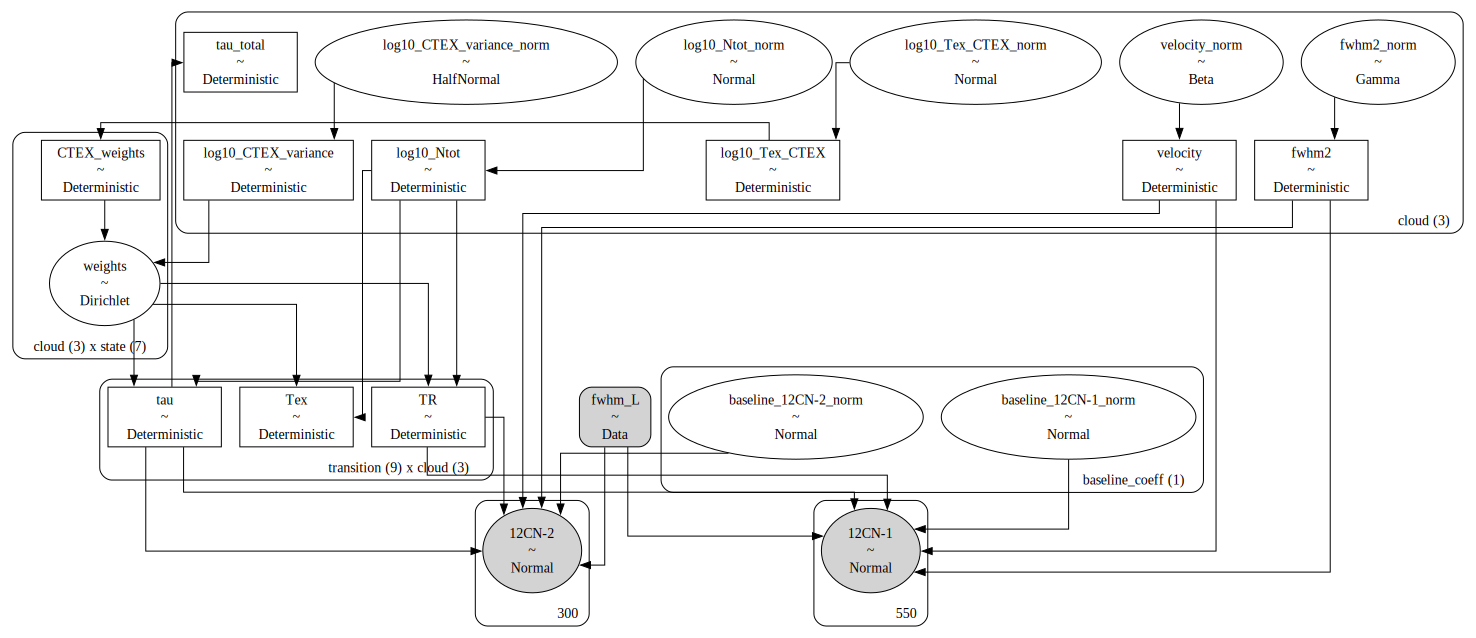

In [47]:
# Plot model graph
model.graph().render('hfs_model_anomalies', format='png')
model.graph()

In [48]:
# model string representation
print(model.model.str_repr())

    baseline_12CN-1_norm ~ Normal(0, 1)
    baseline_12CN-2_norm ~ Normal(0, 1)
         log10_Ntot_norm ~ Normal(0, 1)
              fwhm2_norm ~ Gamma(0.5, f())
           velocity_norm ~ Beta(2, 2)
     log10_Tex_CTEX_norm ~ Normal(0, 1)
log10_CTEX_variance_norm ~ HalfNormal(0, 1)
                 weights ~ Dirichlet(f(log10_CTEX_variance_norm, log10_Tex_CTEX_norm))
              log10_Ntot ~ Deterministic(f(log10_Ntot_norm))
                   fwhm2 ~ Deterministic(f(fwhm2_norm))
                velocity ~ Deterministic(f(velocity_norm))
          log10_Tex_CTEX ~ Deterministic(f(log10_Tex_CTEX_norm))
            CTEX_weights ~ Deterministic(f(log10_Tex_CTEX_norm))
     log10_CTEX_variance ~ Deterministic(f(log10_CTEX_variance_norm))
                     Tex ~ Deterministic(f(weights, log10_Ntot_norm))
                     tau ~ Deterministic(f(weights, log10_Ntot_norm))
               tau_total ~ Deterministic(f(weights, log10_Ntot_norm))
                      TR ~ Deterministic(f

Sampling: [12CN-1, 12CN-2, baseline_12CN-1_norm, baseline_12CN-2_norm, fwhm2_norm, log10_CTEX_variance_norm, log10_Ntot_norm, log10_Tex_CTEX_norm, velocity_norm, weights]


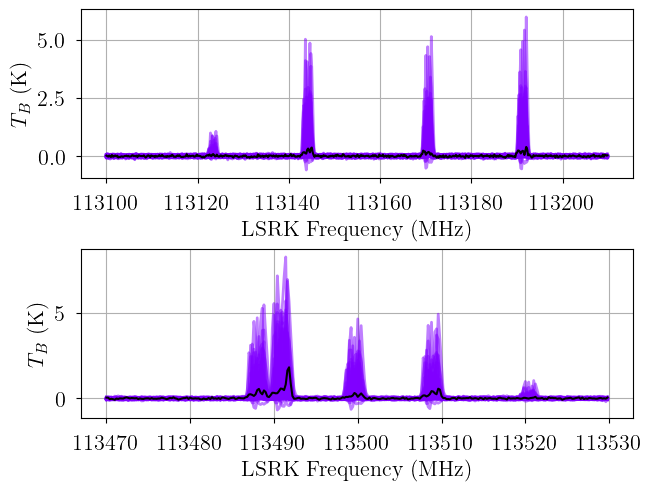

In [10]:
from bayes_spec.plots import plot_predictive

# prior predictive check
prior = model.sample_prior_predictive(
    samples=1000,  # prior predictive samples
)
_ = plot_predictive(model.data, prior.prior_predictive.sel(draw=slice(None, None, 20)))

In [11]:
print(model.cloud_freeRVs)
print(model.cloud_deterministics)

['log10_Ntot_norm', 'fwhm2_norm', 'velocity_norm', 'log10_Tex_CTEX_norm', 'log10_CTEX_variance_norm', 'weights']
['log10_Ntot', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'CTEX_weights', 'log10_CTEX_variance', 'Tex', 'tau', 'tau_total', 'TR']


['log10_Ntot', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'log10_CTEX_variance', 'tau_total']


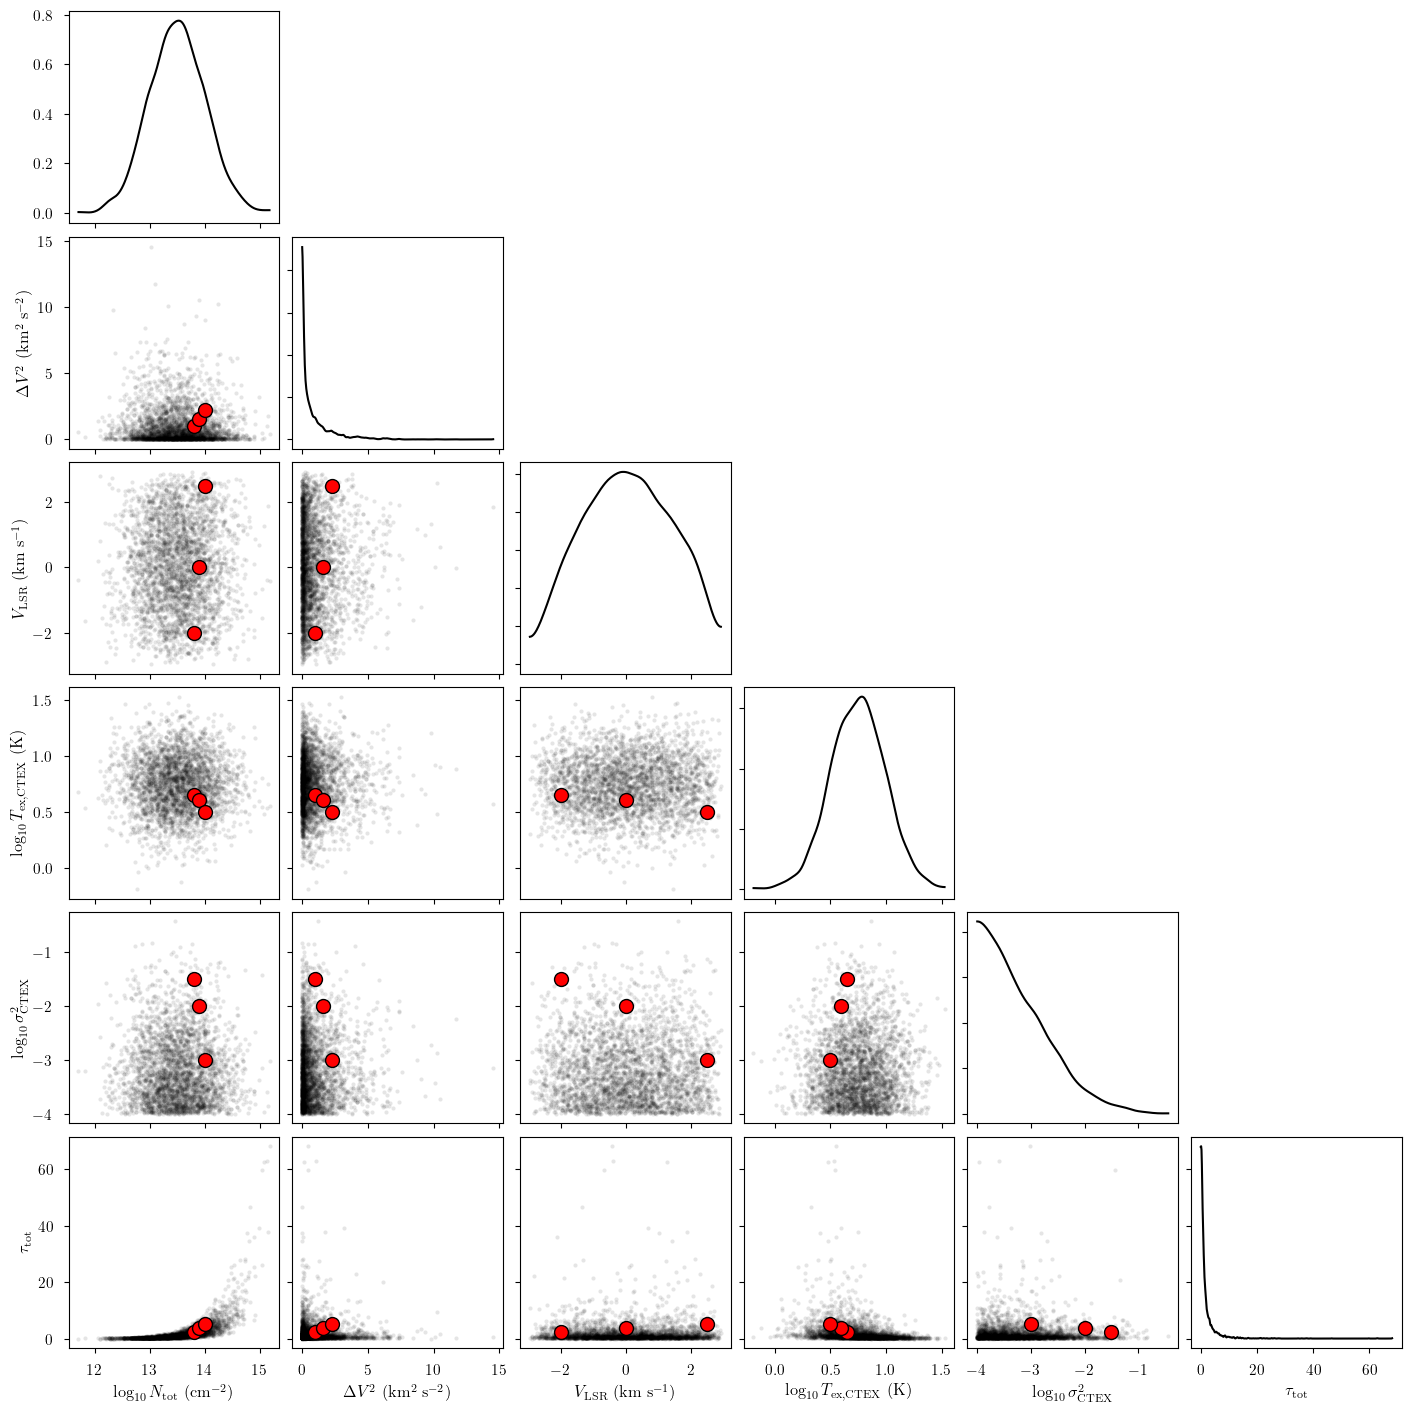

In [12]:
from bayes_spec.plots import plot_pair

var_names = [
    param for param in model.cloud_deterministics + [p for p in model.cloud_freeRVs if "_norm" not in p]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    prior.prior, # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

## Variational Inference

In [13]:
start = time.time()
model.fit(
    n = 1_000_000, # maximum number of VI iterations
    draws = 1_000, # number of posterior samples
    rel_tolerance = 0.005, # VI relative convergence threshold
    abs_tolerance = 0.005, # VI absolute convergence threshold
    learning_rate = 0.001, # VI learning rate
    start = {"velocity_norm": np.linspace(0.1, 0.9, model.n_clouds)},
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Output()

Convergence achieved at 72200
Interrupted at 72,199 [7%]: Average Loss = 3.1274e+26


Adding log-likelihood to trace


Output()

Runtime: 11.30 minutes


In [14]:
pm.summary(model.trace.posterior)

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_12CN-1_norm[0]          0.009  0.042  -0.065    0.092      0.001   
baseline_12CN-2_norm[0]         -0.003  0.061  -0.109    0.119      0.002   
log10_Ntot_norm[0]              -0.106  0.009  -0.123   -0.088      0.000   
log10_Ntot_norm[1]              -0.053  0.018  -0.085   -0.017      0.001   
log10_Ntot_norm[2]              -0.318  0.027  -0.370   -0.269      0.001   
log10_Tex_CTEX_norm[0]           0.682  0.512  -0.290    1.613      0.016   
log10_Tex_CTEX_norm[1]          -0.157  0.185  -0.472    0.229      0.006   
log10_Tex_CTEX_norm[2]          -0.163  0.137  -0.440    0.083      0.004   
fwhm2_norm[0]                    1.479  0.043   1.395    1.557      0.001   
fwhm2_norm[1]                    2.119  0.108   1.914    2.316      0.004   
fwhm2_norm[2]                    3.965  0.277   3.449    4.481      0.011   
velocity_norm[0]                 0.167  0.001   0.164    0.169      0.000   
velocity_norm[1]                 0.504  0.003   0.499    0.510      0.000   
velocity_norm[2]                 0.914  0.006   0.902    0.924      0.000   
log10_CTEX_variance_norm[0]      3.039  0.207   2.624    3.394      0.006   
log10_CTEX_variance_norm[1]      2.360  0.220   1.957    2.748      0.007   
log10_CTEX_variance_norm[2]      2.113  0.226   1.676    2.541      0.007   
weights[0, 0 0 1 1 -- --]        0.238  0.002   0.235    0.242      0.000   
weights[0, 0 0 1 2 -- --]        0.182  0.001   0.179    0.184      0.000   
weights[0, 1 0 1 1 -- --]        0.053  0.001   0.052    0.055      0.000   
weights[0, 1 0 1 2 -- --]        0.090  0.001   0.088    0.092      0.000   
weights[0, 1 0 2 1 -- --]        0.064  0.001   0.063    0.066      0.000   
weights[0, 1 0 2 2 -- --]        0.148  0.001   0.146    0.151      0.000   
weights[0, 1 0 2 3 -- --]        0.224  0.004   0.216    0.232      0.000   
weights[1, 0 0 1 1 -- --]        0.162  0.003   0.156    0.166      0.000   
weights[1, 0 0 1 2 -- --]        0.332  0.003   0.327    0.338      0.000   
weights[1, 1 0 1 1 -- --]        0.062  0.001   0.060    0.064      0.000   
weights[1, 1 0 1 2 -- --]        0.089  0.002   0.086    0.092      0.000   
weights[1, 1 0 2 1 -- --]        0.057  0.001   0.055    0.059      0.000   
weights[1, 1 0 2 2 -- --]        0.150  0.002   0.147    0.154      0.000   
weights[1, 1 0 2 3 -- --]        0.148  0.005   0.138    0.158      0.000   
weights[2, 0 0 1 1 -- --]        0.155  0.004   0.148    0.162      0.000   
weights[2, 0 0 1 2 -- --]        0.339  0.004   0.331    0.346      0.000   
weights[2, 1 0 1 1 -- --]        0.060  0.002   0.057    0.063      0.000   
weights[2, 1 0 1 2 -- --]        0.133  0.003   0.128    0.138      0.000   
weights[2, 1 0 2 1 -- --]        0.045  0.001   0.043    0.048      0.000   
weights[2, 1 0 2 2 -- --]        0.121  0.003   0.116    0.126      0.000   
weights[2, 1 0 2 3 -- --]        0.147  0.008   0.133    0.162      0.000   
log10_Ntot[0]                   13.447  0.005  13.438   13.456      0.000   
log10_Ntot[1]                   13.474  0.009  13.458   13.492      0.000   
log10_Ntot[2]                   13.341  0.013  13.315   13.366      0.000   
fwhm2[0]                         1.479  0.043   1.395    1.557      0.001   
fwhm2[1]                         2.119  0.108   1.914    2.316      0.004   
fwhm2[2]                         3.965  0.277   3.449    4.481      0.011   
velocity[0]                     -1.999  0.008  -2.014   -1.984      0.000   
velocity[1]                      0.026  0.018  -0.007    0.057      0.001   
velocity[2]                      2.482  0.035   2.414    2.545      0.001   
log10_Tex_CTEX[0]                0.920  0.128   0.678    1.153      0.004   
log10_Tex_CTEX[1]                0.711  0.046   0.632    0.807      0.001   
log10_Tex_CTEX[2]                0.709  0.034   0.640    0.771      0.001   
CTEX_weights[0, 0 0 1 1 -- --]   0.133  0.017   0.104    0.162      0.001   
CTEX_weights[0, 0 0 1 2 -- --]

Sampling: [12CN-1, 12CN-2]


Output()

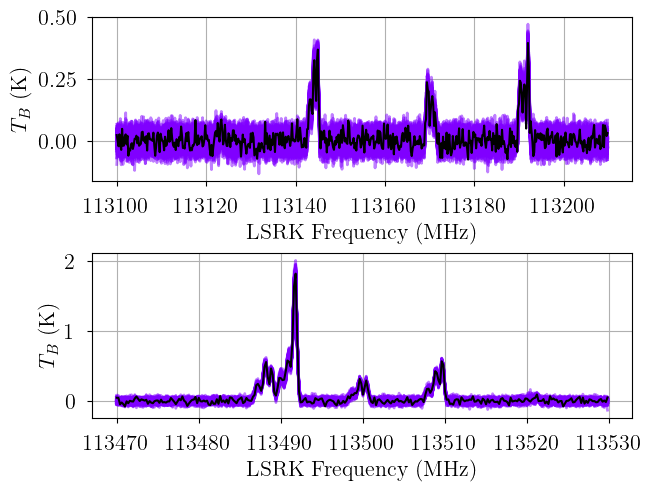

In [15]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

## MCMC
We increase `target_accept` since this model has some degeneracies.

In [16]:
start = time.time()
model.sample(
    init="advi+adapt_diag",  # initialization strategy
    tune=1000,  # tuning samples
    draws=1000,  # posterior samples
    chains=8,  # number of independent chains
    cores=8,  # number of parallel chains
    init_kwargs={
        "rel_tolerance": 0.005,
        "abs_tolerance": 0.005,
        "learning_rate": 0.001,
        "start": {"velocity_norm": np.linspace(0.1, 0.9, model.n_clouds)},
    },  # VI initialization arguments
    nuts_kwargs={"target_accept": 0.9},  # NUTS arguments
)
end = time.time()
print(f"Runtime: {(end-start)/60.0:.2f} minutes")

Initializing NUTS using custom advi+adapt_diag strategy


Output()

Convergence achieved at 72200
Interrupted at 72,199 [7%]: Average Loss = 3.1274e+26
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [baseline_12CN-1_norm, baseline_12CN-2_norm, log10_Ntot_norm, fwhm2_norm, velocity_norm, log10_Tex_CTEX_norm, log10_CTEX_variance_norm, weights]


Output()

Sampling 8 chains for 1_000 tune and 1_000 draw iterations (8_000 + 8_000 draws total) took 396 seconds.


Adding log-likelihood to trace


Output()

Runtime: 18.16 minutes


In [32]:
model.solve(
    init_params="random_from_data", # GMM initialization strategy
    n_init=10, # number of GMM initilizations
    max_iter=1_000, # maximum number of GMM iterations
    kl_div_threshold=0.1, # covergence threshold
)

GMM converged to unique solution


In [33]:
print("solutions:", model.solutions)
az.summary(model.trace.solution_0)
# this also works: az.summary(model.trace.solution_0)

solutions: [0]


mean     sd  hdi_3%  hdi_97%  mcse_mean  \
baseline_12CN-1_norm[0]          0.012  0.045  -0.069    0.098      0.000   
baseline_12CN-2_norm[0]          0.004  0.064  -0.123    0.117      0.001   
log10_Ntot_norm[0]               0.464  0.137   0.205    0.714      0.003   
log10_Ntot_norm[1]               0.851  0.196   0.469    1.200      0.005   
log10_Ntot_norm[2]               0.909  0.255   0.406    1.359      0.008   
log10_Tex_CTEX_norm[0]          -0.299  0.302  -0.790    0.316      0.005   
log10_Tex_CTEX_norm[1]          -0.815  0.103  -0.989   -0.628      0.002   
log10_Tex_CTEX_norm[2]          -0.950  0.086  -1.077   -0.796      0.003   
fwhm2_norm[0]                    1.118  0.107   0.920    1.318      0.002   
fwhm2_norm[1]                    1.499  0.193   1.140    1.861      0.004   
fwhm2_norm[2]                    3.196  0.449   2.383    4.035      0.010   
velocity_norm[0]                 0.165  0.002   0.162    0.169      0.000   
velocity_norm[1]                 0.495  0.005   0.487    0.504      0.000   
velocity_norm[2]                 0.910  0.008   0.895    0.925      0.000   
log10_CTEX_variance_norm[0]      2.627  0.249   2.175    3.110      0.004   
log10_CTEX_variance_norm[1]      1.737  0.281   1.259    2.289      0.005   
log10_CTEX_variance_norm[2]      1.069  0.380   0.342    1.773      0.009   
weights[0, 0 0 1 1 -- --]        0.230  0.006   0.220    0.241      0.000   
weights[0, 0 0 1 2 -- --]        0.301  0.021   0.263    0.338      0.000   
weights[0, 1 0 1 1 -- --]        0.043  0.002   0.039    0.047      0.000   
weights[0, 1 0 1 2 -- --]        0.078  0.003   0.073    0.083      0.000   
weights[0, 1 0 2 1 -- --]        0.049  0.003   0.043    0.055      0.000   
weights[0, 1 0 2 2 -- --]        0.110  0.007   0.098    0.124      0.000   
weights[0, 1 0 2 3 -- --]        0.188  0.006   0.178    0.200      0.000   
weights[1, 0 0 1 1 -- --]        0.201  0.006   0.190    0.212      0.000   
weights[1, 0 0 1 2 -- --]        0.411  0.010   0.391    0.428      0.000   
weights[1, 1 0 1 1 -- --]        0.044  0.003   0.040    0.049      0.000   
weights[1, 1 0 1 2 -- --]        0.074  0.002   0.070    0.078      0.000   
weights[1, 1 0 2 1 -- --]        0.041  0.002   0.037    0.045      0.000   
weights[1, 1 0 2 2 -- --]        0.100  0.007   0.089    0.112      0.000   
weights[1, 1 0 2 3 -- --]        0.129  0.003   0.124    0.133      0.000   
weights[2, 0 0 1 1 -- --]        0.211  0.008   0.197    0.222      0.000   
weights[2, 0 0 1 2 -- --]        0.429  0.011   0.410    0.445      0.000   
weights[2, 1 0 1 1 -- --]        0.040  0.003   0.036    0.045      0.000   
weights[2, 1 0 1 2 -- --]        0.084  0.006   0.076    0.094      0.000   
weights[2, 1 0 2 1 -- --]        0.036  0.002   0.033    0.039      0.000   
weights[2, 1 0 2 2 -- --]        0.081  0.005   0.074    0.090      0.000   
weights[2, 1 0 2 3 -- --]        0.119  0.003   0.114    0.125      0.000   
log10_Ntot[0]                   13.732  0.069  13.603   13.857      0.001   
log10_Ntot[1]                   13.926  0.098  13.735   14.100      0.002   
log10_Ntot[2]                   13.955  0.128  13.703   14.179      0.004   
fwhm2[0]                         1.118  0.107   0.920    1.318      0.002   
fwhm2[1]                         1.499  0.193   1.140    1.861      0.004   
fwhm2[2]                         3.196  0.449   2.383    4.035      0.010   
velocity[0]                     -2.008  0.011  -2.028   -1.987      0.000   
velocity[1]                     -0.031  0.027  -0.080    0.023      0.000   
velocity[2]                      2.459  0.048   2.370    2.549      0.001   
log10_Tex_CTEX[0]                0.675  0.076   0.553    0.829      0.001   
log10_Tex_CTEX[1]                0.546  0.026   0.503    0.593      0.001   
log10_Tex_CTEX[2]                0.512  0.021   0.481    0.551      0.001   
CTEX_weights[0, 0 0 1 1 -- --]   0.172  0.016   0.141    0.200      0.000   
CTEX_weights[0, 0 0 1 2 -- --]

Sampling: [12CN-1, 12CN-2]


Output()

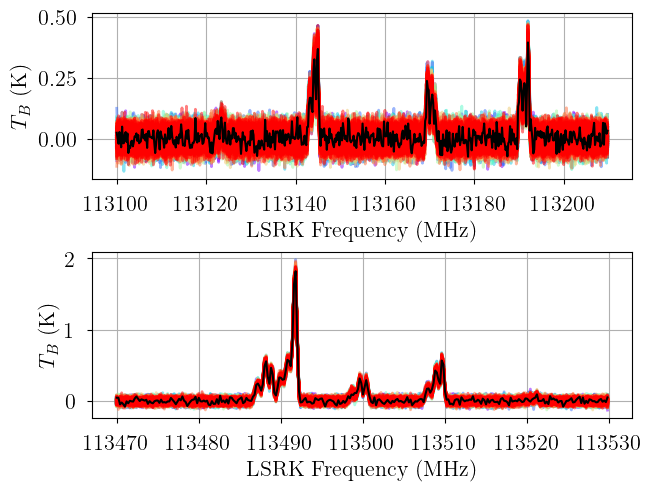

In [34]:
posterior = model.sample_posterior_predictive(
    thin=10, # keep one in {thin} posterior samples
)
_ = plot_predictive(model.data, posterior.posterior_predictive)

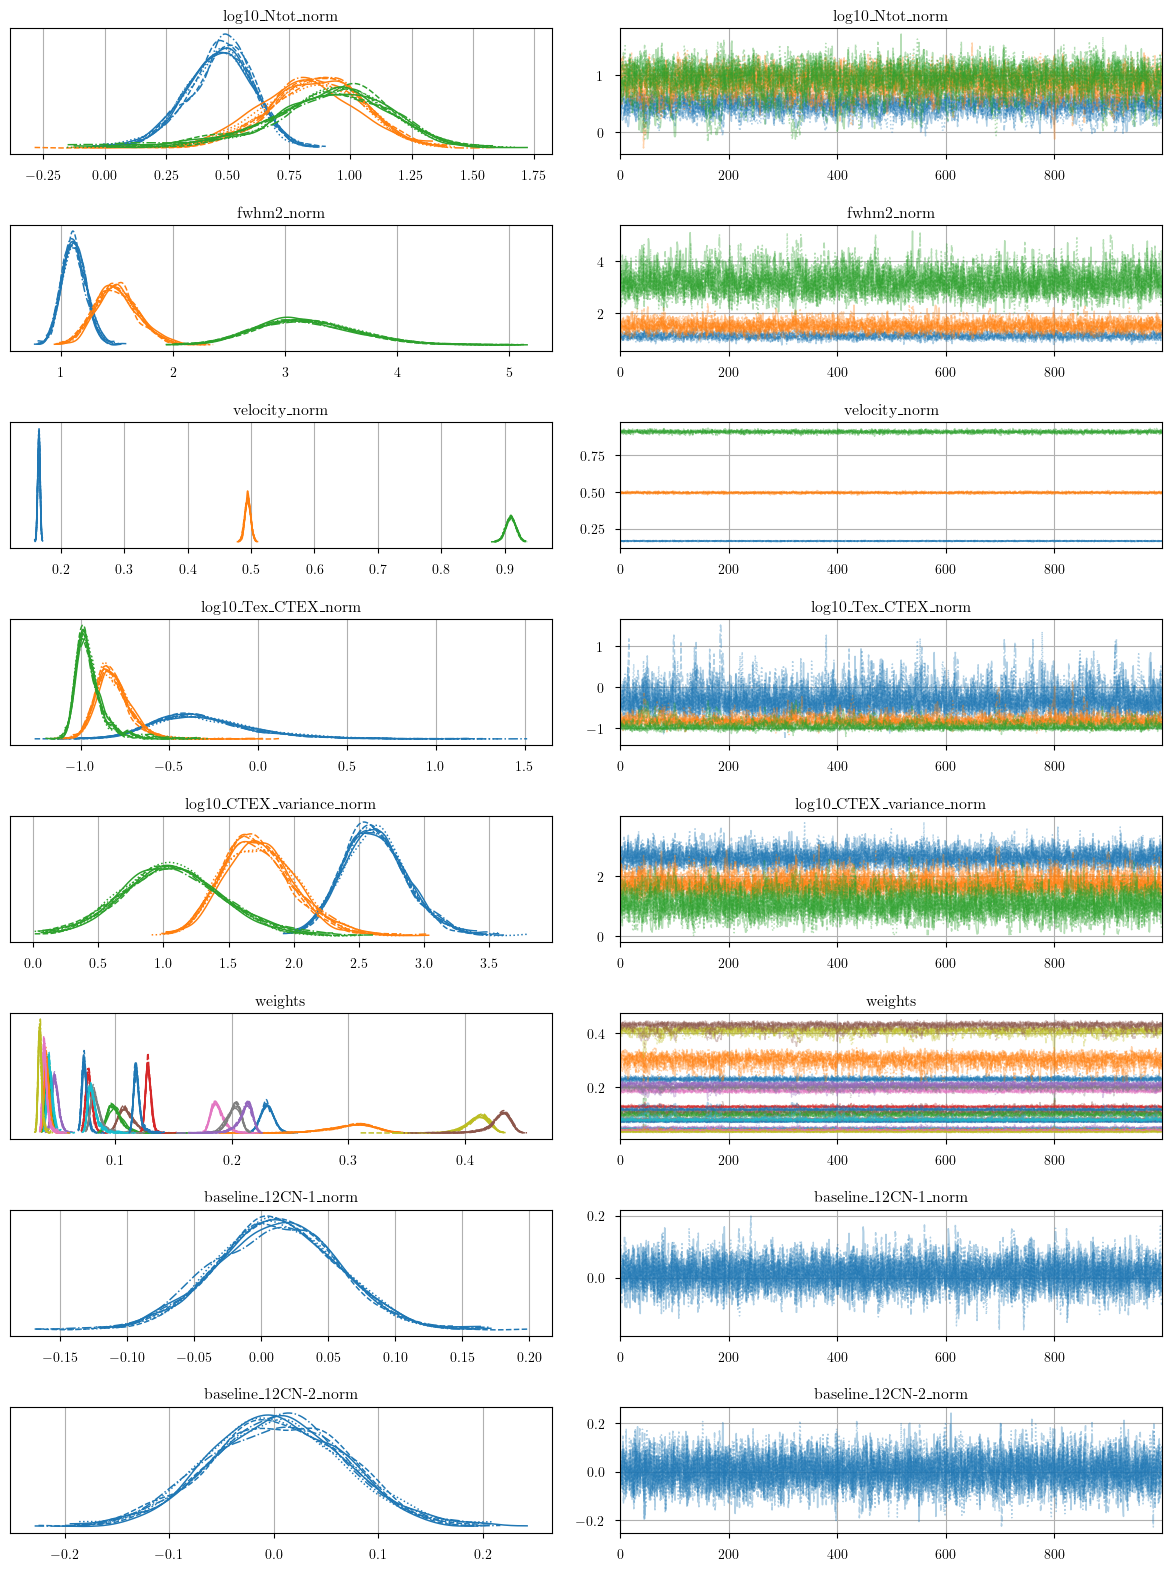

In [35]:
from bayes_spec.plots import plot_traces

axes = plot_traces(model.trace.solution_0, model.cloud_freeRVs + model.baseline_freeRVs + model.hyper_freeRVs)
fig = axes.ravel()[0].figure
fig.tight_layout()

['log10_Ntot_norm', 'fwhm2_norm', 'velocity_norm', 'log10_Tex_CTEX_norm', 'log10_CTEX_variance_norm']


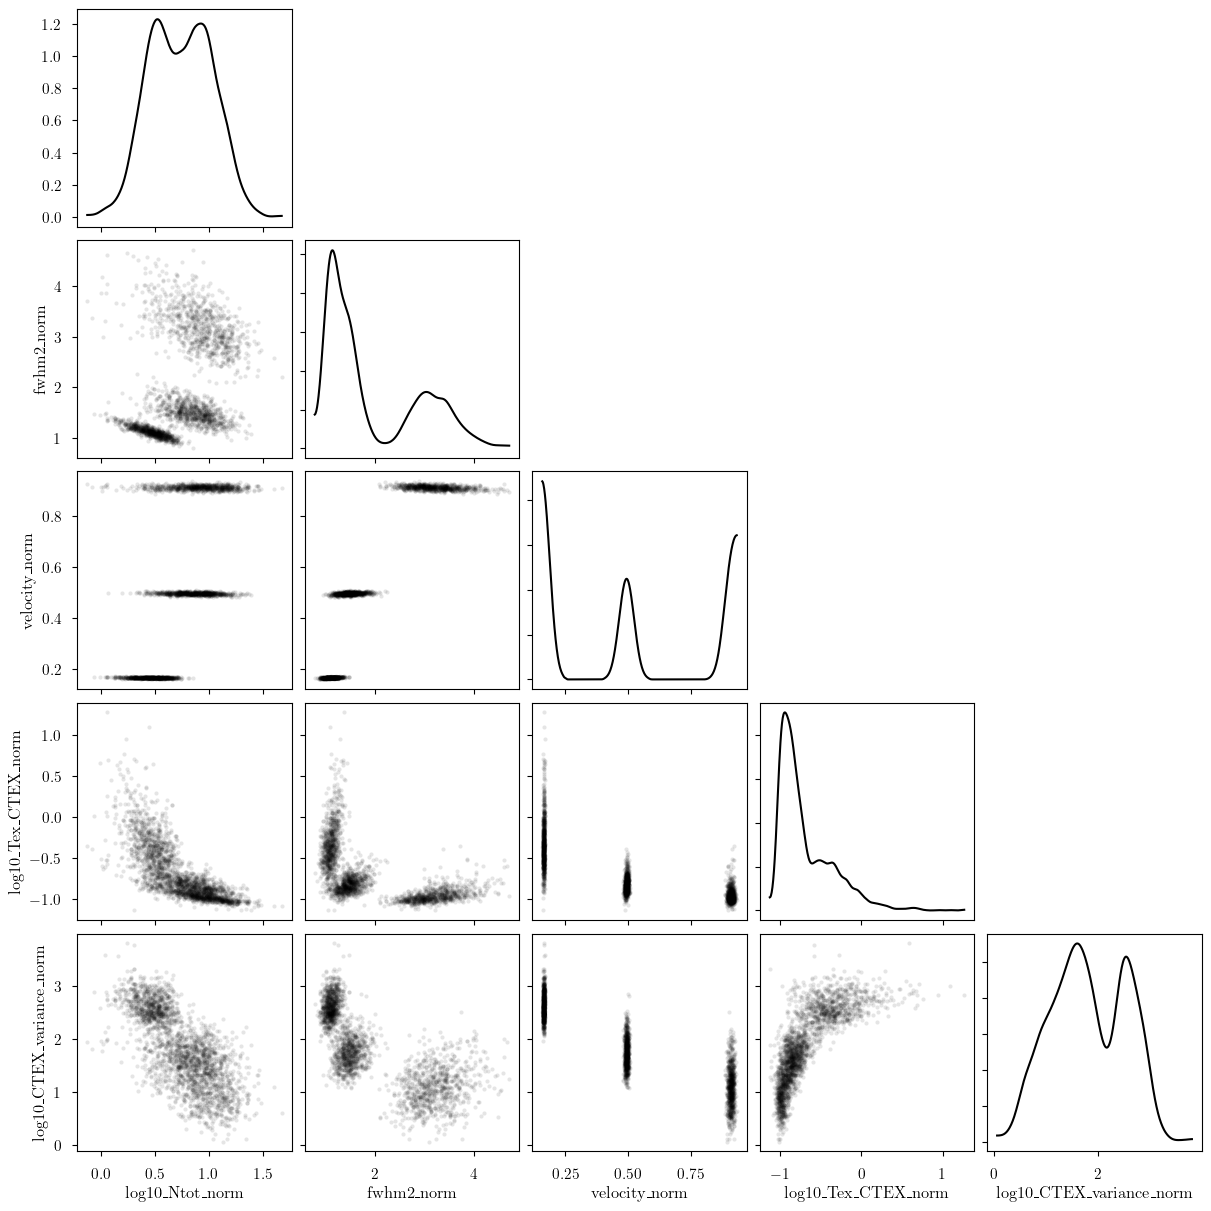

In [36]:
var_names = [
    param for param in model.cloud_freeRVs
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    kind="scatter", # plot type
)

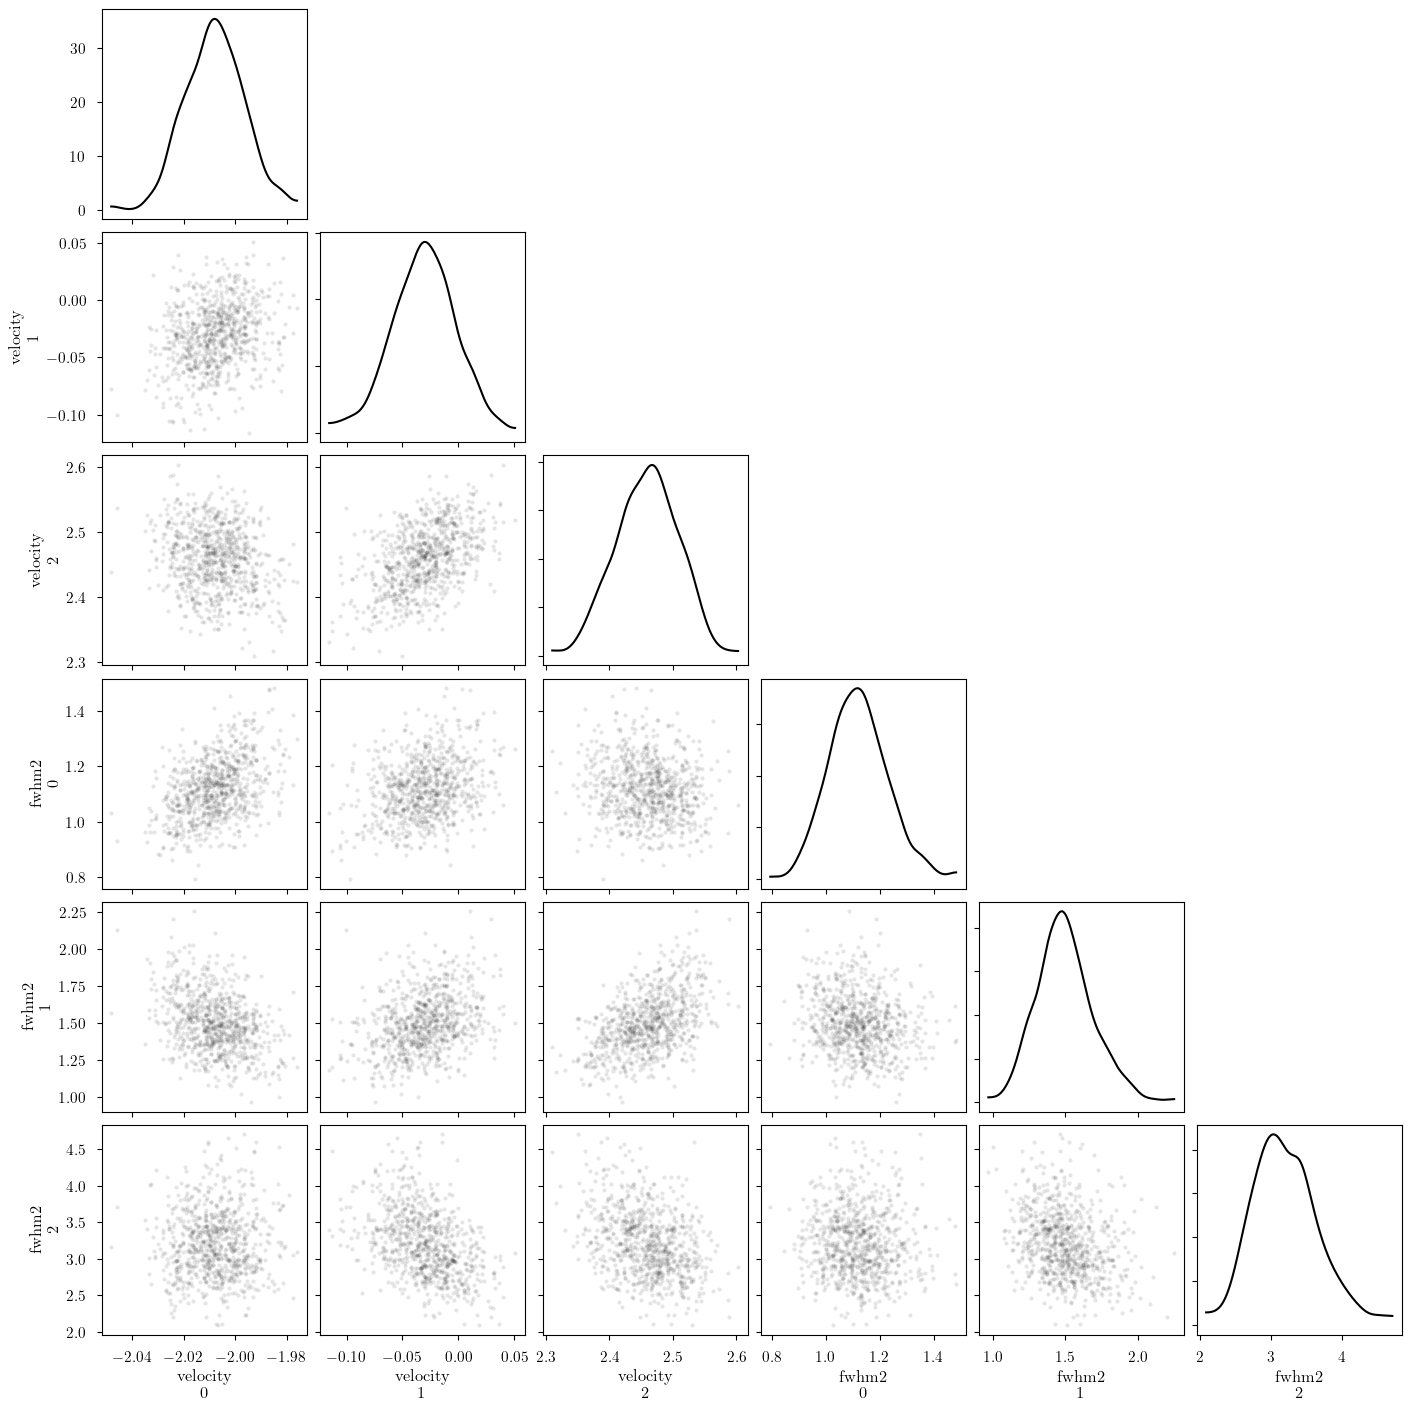

In [37]:
_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    ["velocity", "fwhm2"], # var_names to plot
    combine_dims=None, # do not concatenate clouds
    kind="scatter", # plot type
)

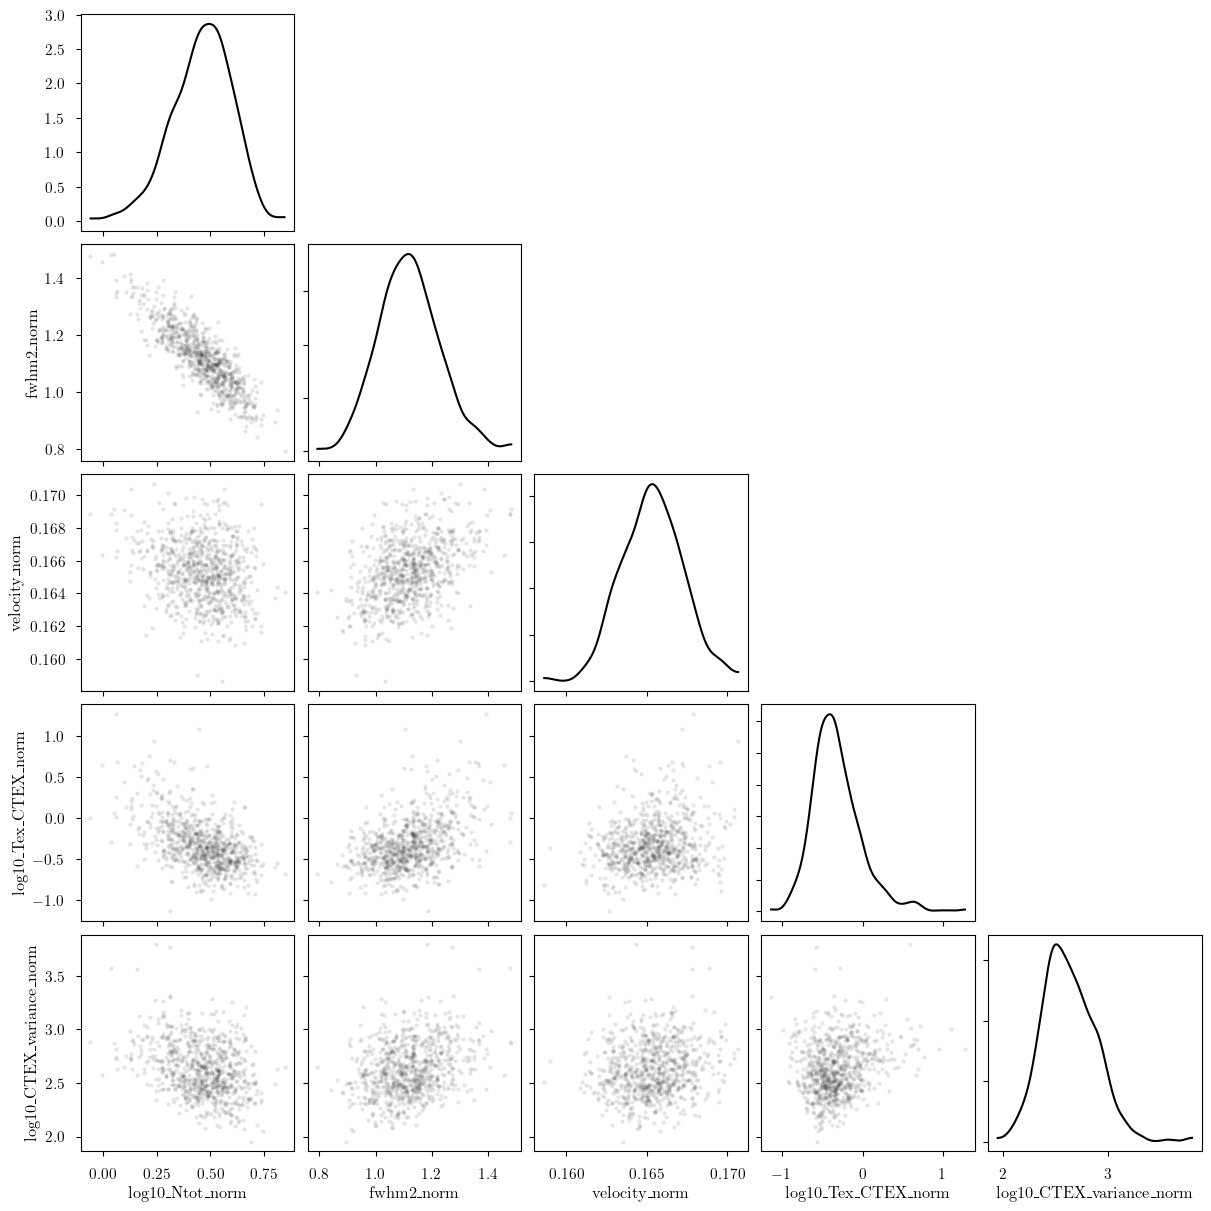

In [38]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=0, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

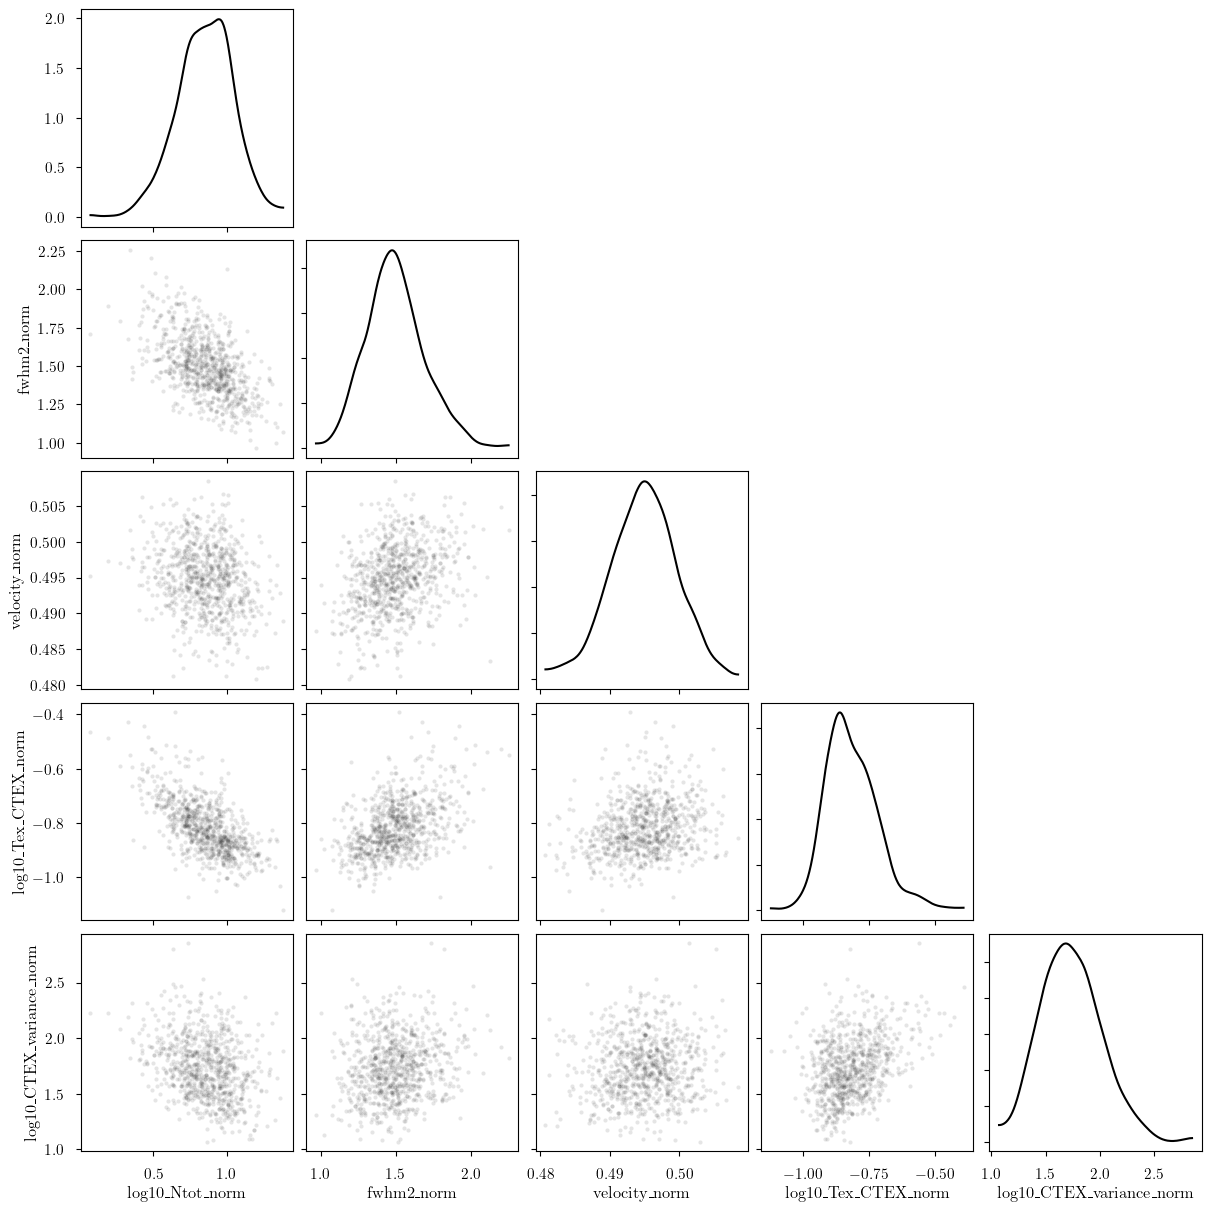

In [39]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=1, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

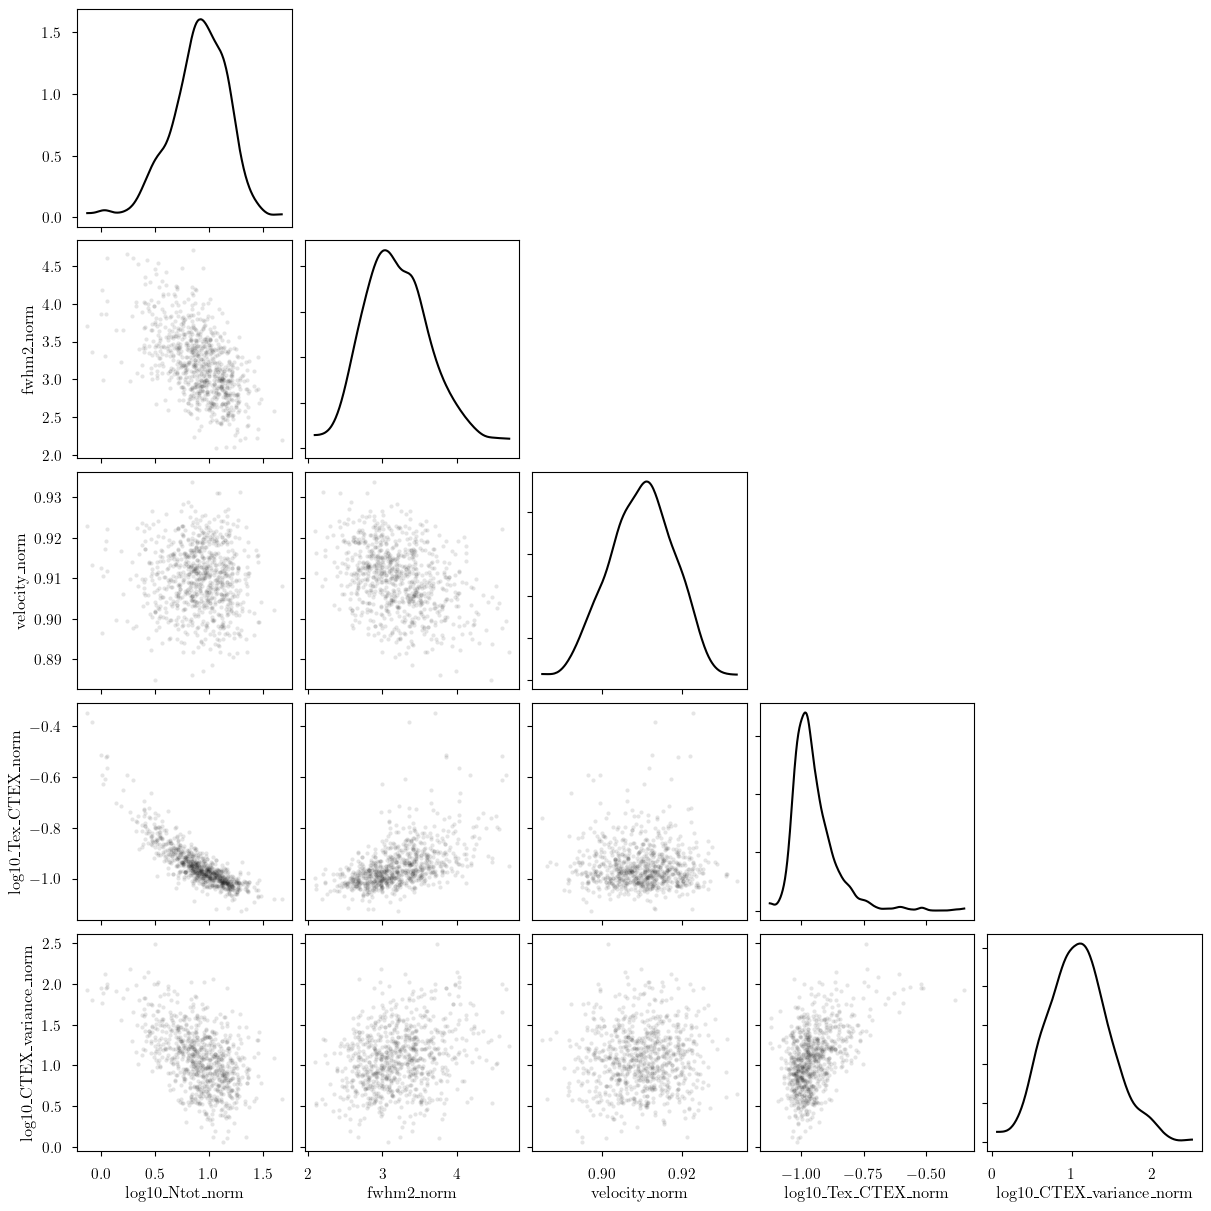

In [40]:
_ = plot_pair(
    model.trace.solution_0.sel(cloud=2, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    kind="scatter", # plot type
)

['log10_Ntot', 'fwhm2', 'velocity', 'log10_Tex_CTEX', 'log10_CTEX_variance', 'tau_total']


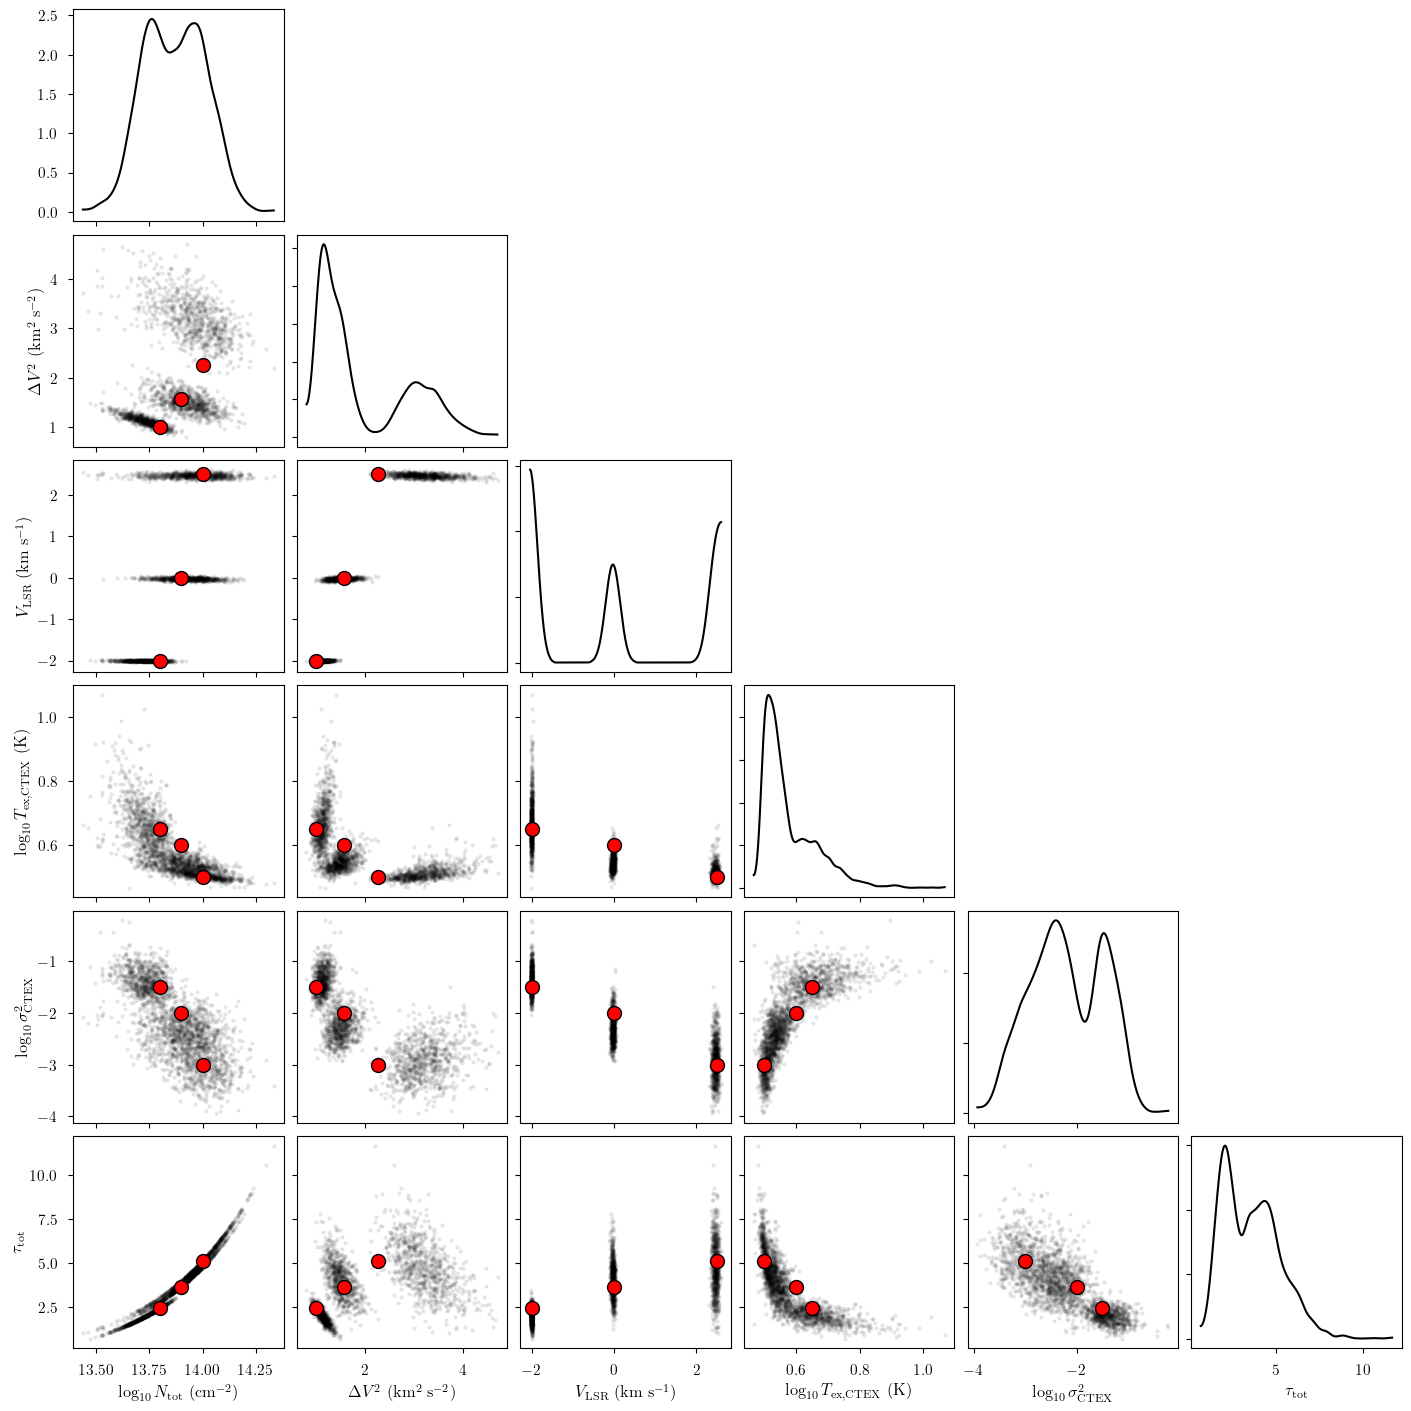

In [41]:
var_names = [
    param for param in model.cloud_deterministics + [p for p in model.cloud_freeRVs if "_norm" not in p]
    if not set(model.model.named_vars_to_dims[param]).intersection(set(["transition", "state"]))
]
print(var_names)

_ = plot_pair(
    model.trace.solution_0.sel(draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    combine_dims=["cloud"], # concatenate clouds
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=sim_params, # truths
)

In [42]:
# identify simulation cloud corresponding to each posterior cloud
sim_cloud_map = {}
for i in range(n_clouds):
    posterior_velocity = model.trace.solution_0['velocity'].sel(cloud=i).data.mean()
    match = np.argmin(np.abs(sim_params["velocity"] - posterior_velocity))
    sim_cloud_map[i] = match
sim_cloud_map

{0: np.int64(0), 1: np.int64(1), 2: np.int64(2)}

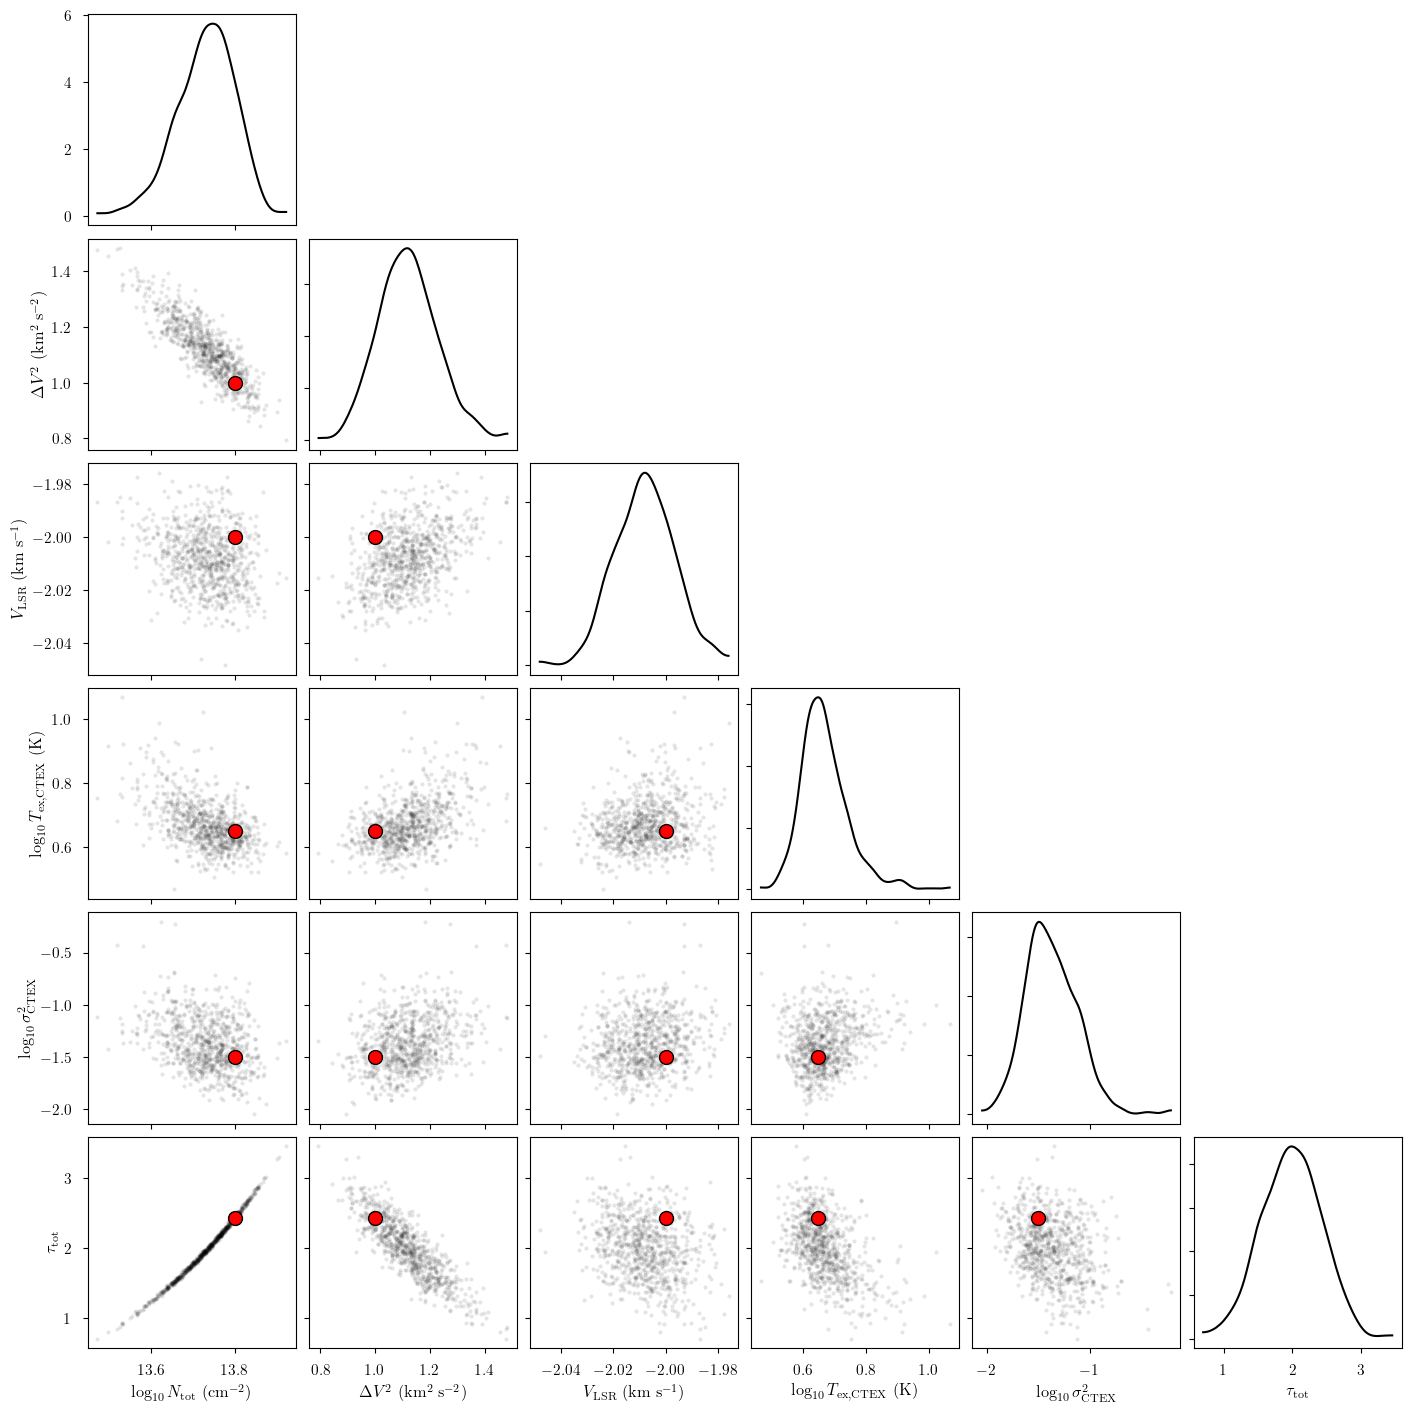

In [43]:
cloud = 0

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]

_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

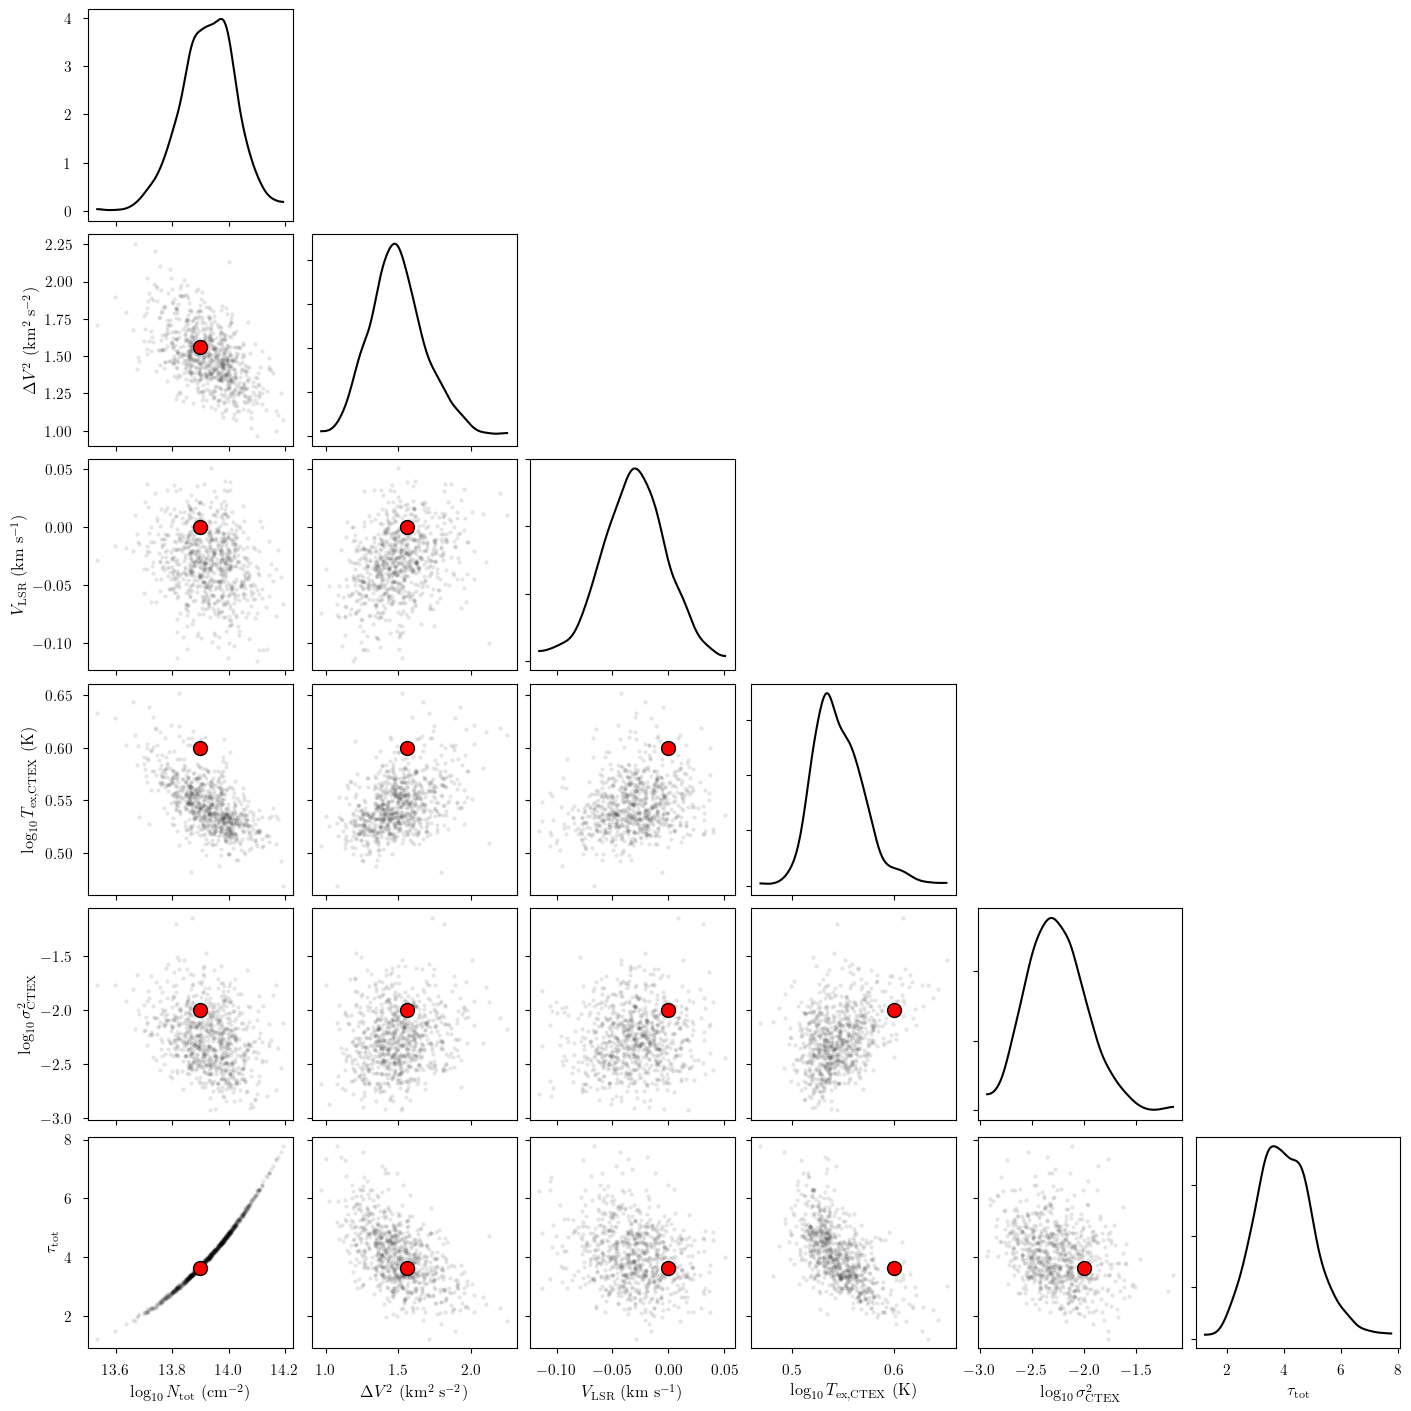

In [44]:
cloud = 1

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
    
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

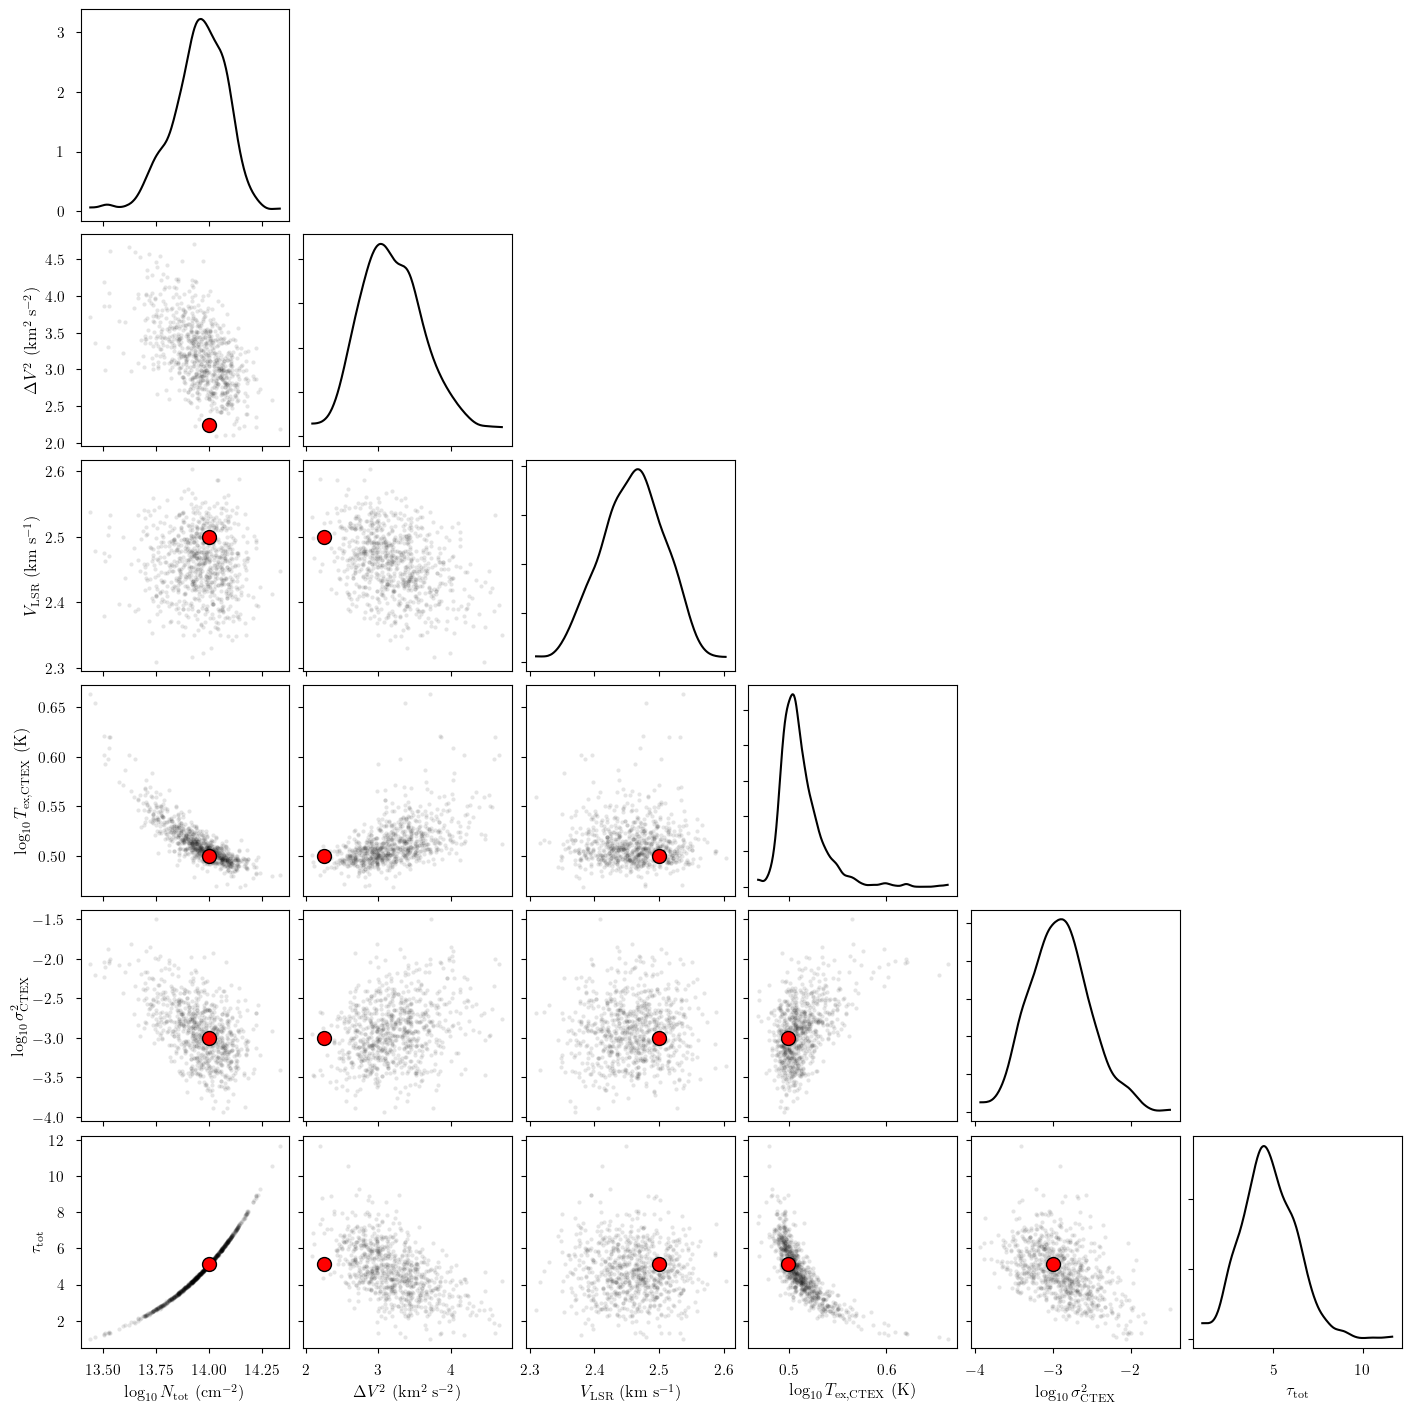

In [45]:
cloud = 2

# subset of sim_params
my_sim_params = {}
for var_name in var_names:
    my_sim_params[var_name] = sim_params[var_name][sim_cloud_map[cloud]]
    
_ = plot_pair(
    model.trace.solution_0.sel(cloud=cloud, draw=slice(None, None, 10)), # samples
    var_names, # var_names to plot
    labeller=model.labeller, # label manager
    kind="scatter", # plot type
    reference_values=my_sim_params, # truths
)

In [46]:
point_stats = az.summary(model.trace.solution_0, kind='stats')
print("BIC:", model.bic())
display(point_stats)

BIC: -3322.9770621368125


mean     sd  hdi_3%  hdi_97%
baseline_12CN-1_norm[0]          0.012  0.045  -0.069    0.098
baseline_12CN-2_norm[0]          0.004  0.064  -0.123    0.117
log10_Ntot_norm[0]               0.464  0.137   0.205    0.714
log10_Ntot_norm[1]               0.851  0.196   0.469    1.200
log10_Ntot_norm[2]               0.909  0.255   0.406    1.359
log10_Tex_CTEX_norm[0]          -0.299  0.302  -0.790    0.316
log10_Tex_CTEX_norm[1]          -0.815  0.103  -0.989   -0.628
log10_Tex_CTEX_norm[2]          -0.950  0.086  -1.077   -0.796
fwhm2_norm[0]                    1.118  0.107   0.920    1.318
fwhm2_norm[1]                    1.499  0.193   1.140    1.861
fwhm2_norm[2]                    3.196  0.449   2.383    4.035
velocity_norm[0]                 0.165  0.002   0.162    0.169
velocity_norm[1]                 0.495  0.005   0.487    0.504
velocity_norm[2]                 0.910  0.008   0.895    0.925
log10_CTEX_variance_norm[0]      2.627  0.249   2.175    3.110
log10_CTEX_variance_norm[1]      1.737  0.281   1.259    2.289
log10_CTEX_variance_norm[2]      1.069  0.380   0.342    1.773
weights[0, 0 0 1 1 -- --]        0.230  0.006   0.220    0.241
weights[0, 0 0 1 2 -- --]        0.301  0.021   0.263    0.338
weights[0, 1 0 1 1 -- --]        0.043  0.002   0.039    0.047
weights[0, 1 0 1 2 -- --]        0.078  0.003   0.073    0.083
weights[0, 1 0 2 1 -- --]        0.049  0.003   0.043    0.055
weights[0, 1 0 2 2 -- --]        0.110  0.007   0.098    0.124
weights[0, 1 0 2 3 -- --]        0.188  0.006   0.178    0.200
weights[1, 0 0 1 1 -- --]        0.201  0.006   0.190    0.212
weights[1, 0 0 1 2 -- --]        0.411  0.010   0.391    0.428
weights[1, 1 0 1 1 -- --]        0.044  0.003   0.040    0.049
weights[1, 1 0 1 2 -- --]        0.074  0.002   0.070    0.078
weights[1, 1 0 2 1 -- --]        0.041  0.002   0.037    0.045
weights[1, 1 0 2 2 -- --]        0.100  0.007   0.089    0.112
weights[1, 1 0 2 3 -- --]        0.129  0.003   0.124    0.133
weights[2, 0 0 1 1 -- --]        0.211  0.008   0.197    0.222
weights[2, 0 0 1 2 -- --]        0.429  0.011   0.410    0.445
weights[2, 1 0 1 1 -- --]        0.040  0.003   0.036    0.045
weights[2, 1 0 1 2 -- --]        0.084  0.006   0.076    0.094
weights[2, 1 0 2 1 -- --]        0.036  0.002   0.033    0.039
weights[2, 1 0 2 2 -- --]        0.081  0.005   0.074    0.090
weights[2, 1 0 2 3 -- --]        0.119  0.003   0.114    0.125
log10_Ntot[0]                   13.732  0.069  13.603   13.857
log10_Ntot[1]                   13.926  0.098  13.735   14.100
log10_Ntot[2]                   13.955  0.128  13.703   14.179
fwhm2[0]                         1.118  0.107   0.920    1.318
fwhm2[1]                         1.499  0.193   1.140    1.861
fwhm2[2]                         3.196  0.449   2.383    4.035
velocity[0]                     -2.008  0.011  -2.028   -1.987
velocity[1]                     -0.031  0.027  -0.080    0.023
velocity[2]                      2.459  0.048   2.370    2.549
log10_Tex_CTEX[0]                0.675  0.076   0.553    0.829
log10_Tex_CTEX[1]                0.546  0.026   0.503    0.593
log10_Tex_CTEX[2]                0.512  0.021   0.481    0.551
CTEX_weights[0, 0 0 1 1 -- --]   0.172  0.016   0.141    0.200
CTEX_weights[0, 0 0 1 2 -- --]   0.345  0.031   0.283    0.399
CTEX_weights[0, 1 0 1 1 -- --]   0.054  0.005   0.045    0.064
CTEX_weights[0, 1 0 1 2 -- --]   0.108  0.010   0.089    0.128
CTEX_weights[0, 1 0 2 1 -- --]   0.054  0.005   0.044    0.064
CTEX_weights[0, 1 0 2 2 -- --]   0.107  0.010   0.089    0.128
CTEX_weights[0, 1 0 2 3 -- --]   0.161  0.016   0.133    0.192
CTEX_weights[1, 0 0 1 1 -- --]   0.204  0.007   0.191    0.216
CTEX_weights[1, 0 0 1 2 -- --]   0.407  0.014   0.381    0.432
CTEX_weights[1, 1 0 1 1 -- --]   0.043  0.002   0.039    0.048
CTEX_weights[1, 1 0 1 2 -- --]   0.087  0.005   0.079    0.095
CTEX_weights[1, 1 0 2 1 -- --]   0.043  0.002   0.039    0.047
CTEX_weights[1, 1 0 2 2 -- --]   0.086  0.005   0.078    0.095
CT